In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.model_selection import  KFold
from sklearn.metrics import recall_score, f1_score, precision_score
from tqdm import tqdm

In [2]:
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.5f}'.format #evita que muestre notacion cientifica
pd.set_option('display.max_columns', None)

In [10]:
class ChangeTrendPercentajeIdentifierWide(BaseEstimator, ClassifierMixin):

    def __init__(self, last_base_value, last_eval_value, threshold, is_wide = True):
        self.last_base_value = last_base_value
        self.last_eval_value = last_eval_value
        self.threshold = threshold
        self.is_wide = is_wide
        
    def convert_wide(self, df):
        df_wide=pd.pivot(df, index=['index'], columns=['date'], values=['consumo']).reset_index()
        df_wide.columns = ['index']+[str(i)+'_anterior' for i in range(self.last_eval_value + self.last_base_value)][::-1]
        return df_wide
    
    def get_cant_cols(self):
        #obtener columnas base y columnas usadas para evaluar
        cols_base = [str(i)+'_anterior' for i in range(self.last_eval_value+1,self.last_base_value+self.last_eval_value+1)][::-1]#last_base_value
        cols_eval = [str(i)+'_anterior' for i in range(1,self.last_eval_value+1)][::-1]#last_eval_value
        return cols_base, cols_eval
        
    def compute_trend_percentage_wide(self, X):
        if self.is_wide==False:
            X = self.convert_wide(X)
        
        cols_base, cols_eval = self.get_cant_cols()
        X['trend_perc'] = 100 * X[cols_eval].mean(axis=1)/(X[cols_base].mean(axis=1)+0.000001)
        return X

    def fit(self, X, y=None):
        return self

    def predict(self, X):
        X_copy = X.copy()
        X_copy = self.compute_trend_percentage_wide(X_copy)
        X_copy['is_fraud_trend_perc'] = (100-X_copy['trend_perc']>self.threshold).astype(int)
        return X_copy[['trend_perc','is_fraud_trend_perc']]
    
def llenar_val_vacios_ciclo(df, cant_ciclos_validos):
    cols_consumo = [f'{i}_anterior' for i in range(cant_ciclos_validos, 0, -1)]
    print(cols_consumo)
    df.loc[:, cols_consumo] = df.loc[:, cols_consumo].fillna(method='ffill', axis=1)
    df.loc[:, cols_consumo] = df.loc[:, cols_consumo].fillna(method='bfill', axis=1)
    return df

## Leer datos <a class="anchor" id="leer-csv"></a>

In [11]:
filename = '../../data/clean_data/eegsa_wide_train_data.parquet'
df = pd.read_parquet(filename)
df.shape

(30932, 37)

In [12]:
df.rename(columns={'id_usuario':'uc'}, inplace=True)
df.rename(columns={'id':'index'}, inplace=True)
df.rename(columns={'is_fraud':'target'}, inplace=True)

In [13]:
df = llenar_val_vacios_ciclo(df,12)

['12_anterior', '11_anterior', '10_anterior', '9_anterior', '8_anterior', '7_anterior', '6_anterior', '5_anterior', '4_anterior', '3_anterior', '2_anterior', '1_anterior']


## Particion Train - Test

In [14]:
# Por fechas 
df_train = df[df.date_fizcalizacion<='2022-02-01'].copy()
df_test = df[df.date_fizcalizacion>'2022-02-01'].copy()
cols_to_model = [str(i)+'_anterior' for i in range(1,13)][::-1]
cols_to_model

['12_anterior',
 '11_anterior',
 '10_anterior',
 '9_anterior',
 '8_anterior',
 '7_anterior',
 '6_anterior',
 '5_anterior',
 '4_anterior',
 '3_anterior',
 '2_anterior',
 '1_anterior']

In [15]:
df_train['all_cero'] = (df_train[cols_to_model].sum(axis=1)==0).astype(int)
df_test['all_cero'] = (df_test[cols_to_model].sum(axis=1)==0).astype(int)
X = df_train[df_train.all_cero==0][cols_to_model].copy()
y = df_train[df_train.all_cero==0].target.copy()

X_test = df_test[df_test.all_cero==0][cols_to_model].copy()
y_test = df_test[df_test.all_cero==0].target.copy()

## Busqueda de hiperparametros

In [17]:
n_splits = 3
hiper = {'last_base_value':[1,2,3],
         'last_eval_value':[1,2],
         'threshold':[10,20,30,40,50,60,80,90]
        }
cofig = list(itertools.product(hiper['last_base_value'], hiper['last_eval_value'], hiper['threshold']))

In [18]:
#Get K-folds indices
kf = KFold(n_splits = n_splits,shuffle=True, random_state=20)
kf.get_n_splits(X)

# # K-fold cross validation
result = []
for c in tqdm(cofig, total=len(cofig)):
    last_base_value = c[0]
    last_eval_value = c[1]
    threshold = c[2]
    trend_perc_model = ChangeTrendPercentajeIdentifierWide(last_base_value,last_eval_value,threshold)
    
    result_p_fold = []
    result_r_fold = []
    result_f1_fold = []
    for train_index, val_index in kf.split(X):
        X_train_fold = X.iloc[train_index, :]
        y_train_fold = y.iloc[train_index]
        # fit and pred
        pred = trend_perc_model.predict(X_train_fold)
        y_pred = pred.is_fraud_trend_perc
        result_p_fold.append(precision_score(y_train_fold, y_pred))
        result_r_fold.append(recall_score(y_train_fold, y_pred))
        result_f1_fold.append(f1_score(y_train_fold, y_pred))
    
    result_conf = [c[0],c[1],c[2]] + result_p_fold + result_r_fold + result_f1_fold
    result.append(result_conf)
    
cols_p = ['p_'+str(x) for x in range(kf.get_n_splits(X))]
cols_r = ['r_'+str(x) for x in range(kf.get_n_splits(X))]
cols_f1 = ['f1_'+str(x) for x in range(kf.get_n_splits(X))]
result = pd.DataFrame(result, columns = ['last_base_value','last_eval_value','th']+cols_p+cols_r+cols_f1)
result['mean_p']=result[cols_p].mean(axis=1)
result['mean_r']=result[cols_r].mean(axis=1)
result['mean_f1']=result[cols_f1].mean(axis=1)
result = result.set_index(['last_base_value','last_eval_value']).sort_values('mean_f1',ascending=False)

100%|██████████| 48/48 [00:02<00:00, 17.43it/s]


In [19]:
result.head(10)

th     p_0     p_1     p_2     r_0     r_1  \
last_base_value last_eval_value                                               
1               2                90 0.02500 0.02932 0.02591 0.17582 0.21111   
2               2                90 0.02413 0.02811 0.02504 0.17582 0.21111   
3               2                90 0.02385 0.02754 0.02446 0.17582 0.21111   
1               2                80 0.02296 0.02718 0.02374 0.17582 0.21111   
                1                80 0.02326 0.02791 0.02088 0.21978 0.26667   
                1                90 0.02343 0.02733 0.02114 0.20879 0.24444   
3               1                40 0.02362 0.02564 0.01909 0.36264 0.38889   
2               1                80 0.02250 0.02765 0.02029 0.21978 0.26667   
3               2                80 0.02264 0.02614 0.02208 0.18681 0.22222   
2               1                90 0.02292 0.02673 0.02063 0.20879 0.24444   

                                    r_2    f1_0    f1_1    f1_2  mean_p  \
last_base_value last_eval_value                                           
1               2               0.23288 0.04378 0.05149 0.04664 0.02675   
2               2               0.23288 0.04244 0.04961 0.04521 0.02576   
3               2               0.23288 0.04199 0.04872 0.04427 0.02528   
1               2               0.23288 0.04061 0.04816 0.04309 0.02463   
                1               0.24658 0.04206 0.05053 0.03850 0.02401   
                1               0.23288 0.04213 0.04916 0.03877 0.02397   
3               1               0.35616 0.04435 0.04811 0.03624 0.02278   
2               1               0.24658 0.04082 0.05010 0.03750 0.02348   
3               2               0.23288 0.04038 0.04678 0.04033 0.02362   
2               1               0.23288 0.04130 0.04819 0.03790 0.02343   

                                 mean_r  mean_f1  
last_base_value last_eval_value                   
1               2               0.20660  0.04730  
2               2               0.20660  0.04575  
3               2               0.20660  0.04499  
1               2               0.20660  0.04395  
                1               0.24434  0.04370  
                1               0.22870  0.04335  
3               1               0.36923  0.04290  
2               1               0.24434  0.04281  
3               2               0.21397  0.04250  
2               1               0.22870  0.04247

### Config Elegida

In [20]:
last_base_value,last_eval_value,threshold = 3,1,60
trend_perc_model = ChangeTrendPercentajeIdentifierWide(last_base_value,last_eval_value,threshold)
pred = trend_perc_model.predict(X_test)

In [21]:
100*pred.is_fraud_trend_perc.value_counts(normalize=True)

0   88.71054
1   11.28946
Name: is_fraud_trend_perc, dtype: float64

In [22]:
pred.sort_values('is_fraud_trend_perc',ascending=False).head()

trend_perc  is_fraud_trend_perc
30930     0.00000                    1
19229     0.00000                    1
27738     0.00000                    1
27732     0.00000                    1
27730     0.00000                    1

In [23]:
X_test.head()

12_anterior  11_anterior  10_anterior  9_anterior  8_anterior  \
15525     35.00000     30.00000     93.00000    67.00000    53.00000   
15526      0.00000      0.00000      0.00000     0.00000     2.00000   
15529    187.00000    181.00000    149.00000   151.00000    45.00000   
15530     37.00000     40.00000     41.00000    53.00000    53.00000   
15531     79.00000     79.00000     89.00000    61.00000    63.00000   

       7_anterior  6_anterior  5_anterior  4_anterior  3_anterior  2_anterior  \
15525    57.00000    49.00000    56.00000    49.00000    50.00000    52.00000   
15526     0.00000     0.00000     0.00000     0.00000     0.00000     0.00000   
15529   139.00000   145.00000   167.00000   164.00000   215.00000   201.00000   
15530    41.00000    31.00000    29.00000    37.00000    46.00000    51.00000   
15531    69.00000    68.00000    69.00000    65.00000     0.00000    29.00000   

       1_anterior  
15525    48.00000  
15526     0.00000  
15529   149.00000  
15530    46.00000  
15531    75.00000

In [24]:
usr = 30930
X_test.loc[usr]

12_anterior   132.00000
11_anterior   180.00000
10_anterior   138.00000
9_anterior    149.00000
8_anterior    149.00000
7_anterior    137.00000
6_anterior    112.00000
5_anterior      0.00000
4_anterior      0.00000
3_anterior      0.00000
2_anterior      0.00000
1_anterior      0.00000
Name: 30930, dtype: float64

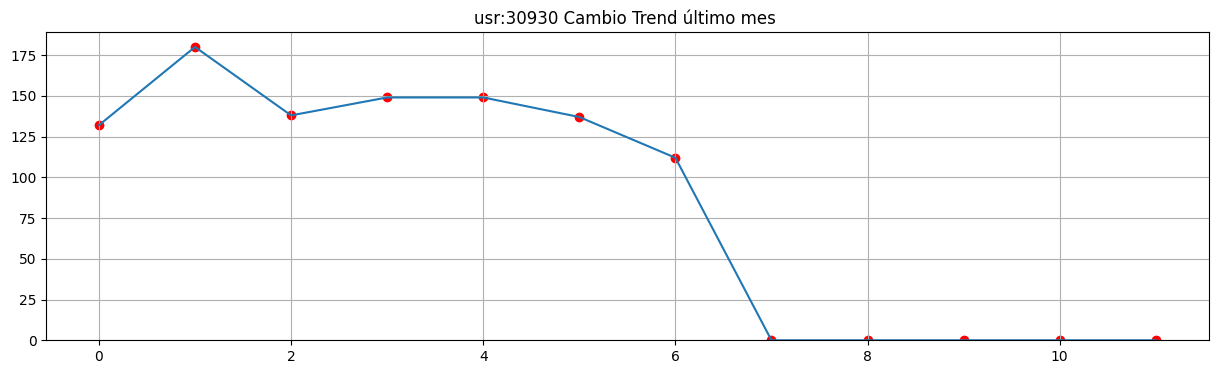

In [25]:
plt.figure(figsize=(15,4))
y = X_test.loc[usr].values
x = range(len(y))
plt.plot(x,y)
plt.scatter(x,y, color='red')
plt.ylim(0.0)
# plt.legend()
plt.grid(True)
plt.title("usr:" + str(usr)+" Cambio Trend último mes ")
plt.show()